# quora-insincere-questions-classification-with-deep-learning

Use the "Run" button to execute the code.

Ref : https://jovian.ai/learn/nautral-language-processing-zero-to-nlp/lesson/neural-networks-and-deep-learning

In [1]:
import os

In [2]:
IS_KAGGLE='KAGGLE_KERNEL_RUN_TYPE' in os.environ

In [3]:
if IS_KAGGLE:
    data_dir = '../input/quora-insincere-questions-classification'
    train_fname = data_dir + '/train.csv'
    test_fname = data_dir + '/test.csv'
    sub_fname = data_dir + '/sample_submission.csv'
else:
    os.environ['KAGGLE_CONFIG_DIR'] = '.'
    !kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p data
    train_fname = 'data/train.csv.zip'
    test_fname = 'data/test.csv.zip'
    sub_fname = 'data/sample_submission.csv.zip' 

 95% 52.0M/54.9M [00:02<00:00, 24.5MB/s]
100% 54.9M/54.9M [00:02<00:00, 22.5MB/s]
 82% 13.0M/15.8M [00:01<00:00, 16.2MB/s]
100% 15.8M/15.8M [00:01<00:00, 14.4MB/s]
 73% 3.00M/4.09M [00:00<00:00, 5.53MB/s]
100% 4.09M/4.09M [00:00<00:00, 6.03MB/s]


In [4]:
import pandas as pd

In [5]:
raw_df=pd.read_csv(train_fname)
test_df=pd.read_csv(test_fname)
sub_df=pd.read_csv(sub_fname)

In [6]:
raw_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [7]:
test_df

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?
...,...,...
375801,ffff7fa746bd6d6197a9,How many countries listed in gold import in in...
375802,ffffa1be31c43046ab6b,Is there an alternative to dresses on formal p...
375803,ffffae173b6ca6bfa563,Where I can find best friendship quotes in Tel...
375804,ffffb1f7f1a008620287,What are the causes of refraction of light?


In [8]:

sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [9]:
if IS_KAGGLE:
  sample_df=raw_df
else:
  sample_df=raw_df[:100_00]

In [10]:
sample_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
9995,01f3d4c0c7566f2f7f1c,Where can one find an online video which demon...,0
9996,01f3e0e7c52adb6d84f6,"Can someone be ""emotionally logic""?",0
9997,01f3ebd3f7bfac05eb37,What are you using for text messaging?,0
9998,01f3ed6a3313dfc76999,How much ml is 16 oz?,0


## Prepare data for training



Outline:
- Convert text to TF-IDF Vectors
- Split training & validation set
- Convert to PyTorch tensors

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
stemmer=SnowballStemmer(language='english')
def tokenize(text):
  return [stemmer.stem(token) for token in word_tokenize(text)]

In [14]:

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
english_stopwords=stopwords.words('english')

In [16]:
vectorizer=TfidfVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=english_stopwords,
    max_features=1000
)

In [17]:
%%time
vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 3.24 s, sys: 33.5 ms, total: 3.28 s
Wall time: 3.33 s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f8eb79e8280>)

In [18]:
%%time
inputs=vectorizer.transform(sample_df.question_text)

CPU times: user 3.07 s, sys: 13.6 ms, total: 3.08 s
Wall time: 3.11 s


In [19]:

inputs.shape

(10000, 1000)

In [20]:
targets=sample_df.target.values

In [21]:
targets.shape

(10000,)

In [22]:
%%time
test_inputs=vectorizer.transform(test_df.question_text)

CPU times: user 1min 51s, sys: 433 ms, total: 1min 51s
Wall time: 1min 52s


## Split train and validation set

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_inputs,val_inputs,train_targets,val_targets=train_test_split(inputs,targets,random_state=42,shuffle=True,test_size=0.3)

In [25]:
train_inputs.shape, val_inputs.shape

((7000, 1000), (3000, 1000))

In [26]:
train_targets.shape , val_targets.shape

((7000,), (3000,))

## Converting PyTorch tensors

In [27]:
import torch
from torch.utils.data import TensorDataset,dataloader
import torch.nn.functional as F

In [28]:
train_tensors = F.normalize(torch.tensor(train_inputs.toarray()).float(), dim=0)
val_tensors = F.normalize(torch.tensor(val_inputs.toarray()).float(), dim=0)


In [29]:

train_tensors.shape, val_tensors.shape



(torch.Size([7000, 1000]), torch.Size([3000, 1000]))

In [30]:
train_ds = TensorDataset(train_tensors, torch.tensor(train_targets))
val_ds = TensorDataset(val_tensors, torch.tensor(val_targets))

In [31]:
batch_size=128
train_dl=dataloader.DataLoader(train_ds,batch_size,shuffle=True)
val_dl=dataloader.DataLoader(val_ds,batch_size)

In [32]:
for inputs_batch,targets_batch in train_dl:
  print('inputs.shape',inputs_batch.shape)
  print('targets.shape',targets_batch.shape)
  print(targets_batch)
  break

inputs.shape torch.Size([128, 1000])
targets.shape torch.Size([128])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])


## Logistic Regression Model

In [33]:
import torch.nn as nn


In [34]:
class LogReg(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1=nn.Linear(1000,1)
  
  def forward(self,xb):
    out=self.linear1(xb)
    return out

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [36]:
logreg_model=LogReg()

In [37]:
for batch in val_dl:
  batch_inputs,batch_targets=batch
  print('input.shape',batch_inputs.shape)
  print('targets',batch_targets)

  batch_out=logreg_model(batch_inputs)
  probs=torch.sigmoid(batch_out[:,0])
  preds=(probs >= 0.5).int()

  print("outputs",preds)
  print("accuracy" , accuracy_score(batch_targets,preds))
  print("f1_score", f1_score(batch_targets,preds))
  break

input.shape torch.Size([128, 1000])
targets tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
outputs tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0], dtype=torch.int32)
accuracy 0.6015625
f1_score 0.03773584905660377


In [38]:
def evaluate(model,dl):
  losses,accs,f1s=[] , [] , []
  for batch in dl:
    inputs,targets=batch
    out=model(inputs)

    probs=torch.sigmoid(out[:,0])
    loss=F.binary_cross_entropy(probs,targets.float(),weight=torch.tensor(20.))
    losses.append(loss.item())

    preds=(probs > 0.5).int()
    acc=accuracy_score(targets,preds)
    f1=f1_score(targets,preds)

    accs.append(aicc)
    f1s.append(f1)

  return np.mean(losses) , np.mean(accs), np.mean(f1s)

In [39]:
def fit(epochs, lr, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            inputs, targets = batch
            out = model(inputs)
            probs = torch.sigmoid(out[:,0])
            loss = F.binary_cross_entropy(probs, 
                                          targets.float(), 
                                          weight=torch.tensor(20.))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [40]:
logreg_model=LogReg()


In [41]:
history=[evaluate(logreg_model,val_dl)]

In [42]:

history

[(14.017566323280334, 0.0992373511904762, 0.11130574347700221)]

In [43]:
%%time
history +=fit(5,0.01,logreg_model,train_dl,val_dl)

Epoch: 0; Loss: 8.6496; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 1; Loss: 6.3262; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 2; Loss: 5.3242; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 3; Loss: 4.8519; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 4; Loss: 4.5949; Accuracy: 0.9380; F1 Score: 0.0000
CPU times: user 836 ms, sys: 28 ms, total: 865 ms
Wall time: 945 ms


In [44]:
history += fit(5, 0.01, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 4.3762; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 1; Loss: 4.2919; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 2; Loss: 4.2099; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 3; Loss: 4.1180; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 4; Loss: 4.0408; Accuracy: 0.9380; F1 Score: 0.0000


In [45]:
history += fit(10, 0.001, logreg_model, train_dl, val_dl)

Epoch: 0; Loss: 4.0360; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 1; Loss: 4.0288; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 2; Loss: 4.0219; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 3; Loss: 4.0151; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 4; Loss: 4.0087; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 5; Loss: 4.0009; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 6; Loss: 3.9940; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 7; Loss: 3.9890; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 8; Loss: 3.9814; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 9; Loss: 3.9753; Accuracy: 0.9380; F1 Score: 0.0000


In [46]:
losses=[item[0] for item in history]

In [47]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss')

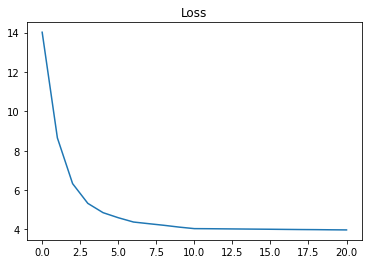

In [48]:
plt.plot(losses)
plt.title('Loss')

Text(0.5, 1.0, 'F1 Score')

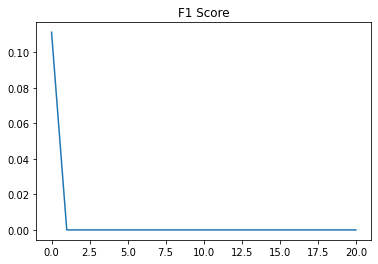

In [49]:
f1s=[item[2] for item in history]
plt.plot(f1s)
plt.title('F1 Score')

## Feed Forward Neural Network

In [50]:
import torch.nn.functional as F

In [54]:
class FeedForwardModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1=nn.Linear(1000,512)
    self.linear2=nn.Linear(512,256)
    self.linear3=nn.Linear(256,128)
    self.linear4=nn.Linear(128,1)

  def forward(self,xb):
    out=F.relu(self.linear1(xb))
    out=F.relu(self.linear2(out))
    out=F.relu(self.linear3(out))
    out=self.linear4(out)

    return out

In [55]:
ff_model=FeedForwardModel()

In [56]:
history=[evaluate(ff_model,val_dl)]

In [57]:
history

[(14.12543515364329, 0.06203497023809523, 0.1161728199304476)]

In [58]:
history +=fit(5,0.001,ff_model,train_dl,val_dl)

Epoch: 0; Loss: 4.3243; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 1; Loss: 3.8005; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 2; Loss: 4.3825; Accuracy: 0.9380; F1 Score: 0.0000
Epoch: 3; Loss: 4.9140; Accuracy: 0.9301; F1 Score: 0.3363
Epoch: 4; Loss: 5.7307; Accuracy: 0.9255; F1 Score: 0.3659


## Make Predictioins and submit

In [59]:
test_tensors=torch.tensor(test_inputs.toarray()).float()

In [60]:
test_ds=TensorDataset(test_tensors)


In [61]:
test_ds

In [69]:
test_dl=dataloader.DataLoader(test_ds,batch_size)

In [70]:
def predict(model,dl):
  all_preds=[]
  for batch in dl:
    inputs,=batch
    out=model(inputs)
    probs=torch.sigmoid(out)[:,0]
    preds=(probs > 0.5).int()
    all_preds +=list(preds.numpy())
  return all_preds

In [71]:

test_preds=predict(ff_model,test_dl)

In [72]:
test_preds[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [73]:
sub_df

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [74]:
sub_df.prediction=test_preds

In [75]:
sub_df.to_csv('submission.csv',index=None)

In [76]:
!head submission.csv

qid,prediction
0000163e3ea7c7a74cd7,0
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
000086e4b7e1c7146103,0
0000c4c3fbe8785a3090,0
000101884c19f3515c1a,0
00010f62537781f44a47,0
00012afbd27452239059,0
00014894849d00ba98a9,0
